# Описание проекта

Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.\
Требуется обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

# Импорты

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Скачиваем пак со стоп-словами
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Пользовательские функции

In [3]:
#  Функция для первичного анализа дата-сета
def analyze_df(df):
    # выводим размерность датафрейма
    display("Размерность датафрейма:")
    display(df.shape)

    
    # выводим информацию о датафрейме
    display("Информация о датафрейме:")
    display(df.info())

    
    # выводим статистическую информацию о датафрейме
    display("Статистическая информация о датафрейме:")
    display(df.describe())
    

    # выводим первые 10 строк датафрейма
    display("Первые 10 строк датафрейма:")
    display(df.head(10))
    

    # выодим кол-во пропусков
    display("Кол-во пропусков")
    display(df.isna().sum()[df.isna().sum() > 0])
    
    
    # выодим кол-во дубликатов
    display("Кол-во дубликатов")
    display(df.duplicated().sum()[df.duplicated().sum() > 0])
    
    # выводим типы данных в столбцах
    display("Типы данных в столбцах")
    display(df.dtypes)
    
    # выводим гистограммы
    display("Гистограммы данных")
    df['toxic'].hist()
    plt.show()

In [4]:
def text_preparing(text):
    text = re.sub(r'[^a-zA-z ]', ' ', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [5]:
def training(model, params):
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(min_df = 1)),
        ('model', model)])
    grid = GridSearchCV(pipeline, cv = 5, n_jobs = -1, param_grid = params ,scoring = 'f1', verbose = False)
    grid.fit(features_train['predproc'], target_train)
    print('Лучший результат:', grid.best_score_)
    print('Лучшие параметры:', grid.best_params_)
    return grid

In [6]:
def text_preparing_pos(text):
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)

    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    token = nltk.word_tokenize(text)
    text = [word for word in token if word not in stop_words]
    text = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text]
    text = ' '.join(text)
    return text

# Загрузка файлов

In [7]:
#  Сохраним файлы в стандартную переменную, используя оба источника
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

# Подготовка данных

'Размерность датафрейма:'

(159292, 3)

'Информация о датафрейме:'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

'Статистическая информация о датафрейме:'

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


'Первые 10 строк датафрейма:'

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


'Кол-во пропусков'

Series([], dtype: int64)

'Кол-во дубликатов'

array([], dtype=int64)

'Типы данных в столбцах'

Unnamed: 0     int64
text          object
toxic          int64
dtype: object

'Гистограммы данных'

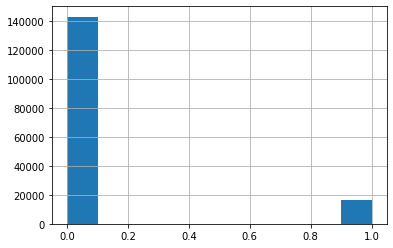

In [8]:
analyze_df(data)

In [9]:
data['predproc'] = data['text'].apply(text_preparing_pos)

In [10]:
# Проверяем
data.head(10)

,Unnamed: 0,text,toxic,predproc
0,0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stuck th...
2,2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,5,"""\n\nCongratulations from me as well, use the ...",0,congratulation well use tool well talk
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article revert plea...
8,8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intend wr...
9,9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


In [11]:
# Объявляем признаки и целевой признак
features = data.drop(['toxic'], axis = 1)
target = data['toxic']

# Проверяем
print('Целевой признак:', target.shape)
print('Признаки:', features.shape)

Целевой признак: (159292,)
Признаки: (159292, 3)


In [12]:
# Деление выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, stratify = target)

# Проверяем
print('Train:', features_train.shape, target_train.shape)
print('Test:', features_test.shape, target_test.shape)

Train: (127433, 3) (127433,)
Test: (31859, 3) (31859,)


# Обучение

## Logistic Regression

In [13]:
lr = training(LogisticRegression(random_state=123, class_weight='balanced'), {"model__C":[0.1, 1.0, 10.0], "model__penalty":["l2"]})

Лучший результат: 0.7658649581399127
Лучшие параметры: {'model__C': 10.0, 'model__penalty': 'l2'}


## Decision Tree Classifier

In [14]:
dt = training(DecisionTreeClassifier(random_state=123, class_weight='balanced'), {'model__max_depth':[2,4,6],
                                                                                  'model__min_samples_split':[2,4,6]})

Лучший результат: 0.5404895804143577
Лучшие параметры: {'model__max_depth': 6, 'model__min_samples_split': 4}


## CatBoost Classifier

In [15]:
cat = training(CatBoostClassifier(random_state=123, logging_level='Silent'), {'model__depth': [4,6],'model__learning_rate' : [0.01,0.03],'model__iterations' : [10, 50]})

Лучший результат: 0.5218514511367285
Лучшие параметры: {'model__depth': 6, 'model__iterations': 50, 'model__learning_rate': 0.03}


## Промежуточный вывод.
Лучшее значение метрики и лучшее время показала модель Логистический регрессии.\
Значение F1 составило 0,77. Обучилась она за 36 сек.

# Тест Логистической регрессии на тестовой выборке

In [16]:
result = f1_score(target_test, lr.predict(features_test['predproc']))
print("Результат LogisticRegression на тестовой выборке", result)

Результат LogisticRegression на тестовой выборке 0.7683518994572979


# Финальный вывод

В ходе выполнения проекта был подготовлен исходный датасет: проведена леммитизация и токенизация текстов средствами библиотеки nltk.\
Протестировано 3 модели: Логистическая регрессия, Дерево решений, Градиентный бустинг в исполнении CatBoost.\
Лучший результат за лучшее время показала модель Логистический регрессии 0,76 по метрике F1 за 36 сек.\
Дерево решений и CatBoost справились со схожим результатом (0,54 и 0.52), но вот время обучение сильно разнится (58 сек против 7,37 сек в пользу первой модели).\